In [1]:
import torch
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
iris = pd.read_csv(r"iris.csv")

In [3]:
iris.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [4]:
len(iris)

150

In [5]:
iris['variety'].value_counts()

Versicolor    50
Virginica     50
Setosa        50
Name: variety, dtype: int64

# Explicitly converting all the labels of the different variety of iris to 1,2 and 3 respectively for classification and comparing the model predictions

In [6]:
map_to_numerics = {'Setosa':0, 'Virginica':1, 'Versicolor':2}
iris['variety_num'] = iris['variety'].map(lambda x: map_to_numerics.get(x) if x in map_to_numerics else x)

In [7]:
iris.head()

,sepal.length,sepal.width,petal.length,petal.width,variety,variety_num
0,5.1,3.5,1.4,0.2,Setosa,0
1,4.9,3.0,1.4,0.2,Setosa,0
2,4.7,3.2,1.3,0.2,Setosa,0
3,4.6,3.1,1.5,0.2,Setosa,0
4,5.0,3.6,1.4,0.2,Setosa,0


In [8]:
iris.tail()

,sepal.length,sepal.width,petal.length,petal.width,variety,variety_num
145,6.7,3.0,5.2,2.3,Virginica,1
146,6.3,2.5,5.0,1.9,Virginica,1
147,6.5,3.0,5.2,2.0,Virginica,1
148,6.2,3.4,5.4,2.3,Virginica,1
149,5.9,3.0,5.1,1.8,Virginica,1


In [9]:
test_indices = np.random.choice(150, 30, replace=False)
all_indices = np.arange(len(iris))
train_indices = np.setdiff1d(all_indices, test_indices)
features = ['sepal.length', 'sepal.width', 'petal.length', 'petal.width']
len(features)

4

In [10]:
train_set_x = iris.loc[train_indices, features]
test_set_x = iris.loc[test_indices, features]

In [11]:
train_set_x_np = train_set_x.values
test_set_x_np = test_set_x.values

In [12]:
train_set_y = iris.loc[train_indices, ('variety_num')]
test_set_y = iris.loc[test_indices, ('variety_num')]

In [13]:
train_set_y_np = train_set_y.values
test_set_y_np = test_set_y.values

In [14]:
train_set_x_tensor = torch.from_numpy(train_set_x_np).to(torch.float32)
test_set_x_tensor = torch.from_numpy(test_set_x_np).to(torch.float32)
train_set_y_tensor = torch.from_numpy(train_set_y_np).to(dtype=torch.long)
test_set_y_tensor = torch.from_numpy(test_set_y_np).to(dtype=torch.long)

# Datasets and Dataloader

In [15]:
# Define dataset
from torch.utils.data import TensorDataset
dataset_train = TensorDataset(train_set_x_tensor, train_set_y_tensor)
dataset_test = TensorDataset(test_set_x_tensor, test_set_y_tensor)

In [16]:
from torch.utils.data import DataLoader

batch_size = 5
train_loader = DataLoader(dataset_train, batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size)

## nn.Linear building the model

In [17]:
import torch.nn as nn
num_classes = 3
input_size = len(features)
model = nn.Linear(input_size, num_classes)
print(model.weight)
print(model.bias)

Parameter containing:
tensor([[ 0.4765, -0.3046,  0.3686, -0.4631],
        [-0.2705, -0.0662,  0.1965, -0.1774],
        [ 0.1809, -0.4195, -0.4400,  0.1558]], requires_grad=True)
Parameter containing:
tensor([-0.2546,  0.2703,  0.1169], requires_grad=True)


In [18]:
print(model.weight.shape)
model.weight

torch.Size([3, 4])


Parameter containing:
tensor([[ 0.4765, -0.3046,  0.3686, -0.4631],
        [-0.2705, -0.0662,  0.1965, -0.1774],
        [ 0.1809, -0.4195, -0.4400,  0.1558]], requires_grad=True)

In [19]:
print(model.bias.shape)
model.bias

torch.Size([3])


Parameter containing:
tensor([-0.2546,  0.2703,  0.1169], requires_grad=True)

In [20]:
for features, labels in train_loader:
    print(features.shape)
    outputs = model(features)
    break

torch.Size([5, 4])


Use softmax to covert the resulting output into a value between 0 and 1. The resulting vector can thus be interpreted as probabilities.

We'll use the implementation that's provided within PyTorch because it works well with multidimensional tensors (a list of output rows in our case).

In [21]:
import torch.nn.functional as F

In [22]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

In [23]:
probs

tensor([[0.9491, 0.0358, 0.0151],
        [0.9916, 0.0067, 0.0018],
        [0.9526, 0.0329, 0.0145],
        [0.9688, 0.0228, 0.0084],
        [0.9485, 0.0332, 0.0183]], grad_fn=<SoftmaxBackward>)

In [24]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([0, 0, 0, 0, 0])
tensor([0.9491, 0.9916, 0.9526, 0.9688, 0.9485], grad_fn=<MaxBackward0>)


In [25]:
labels

tensor([2, 1, 2, 1, 2])

In [26]:
torch.sum(preds == labels)

tensor(0)

## Function to compute accuracy of prediction for a given batch

In [27]:
def accuracy(outputs, labels):
    max_prob, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(torch.eq(preds, labels)).item() / len(preds))

In [28]:
accuracy(outputs, labels)   # Obviously it would be very small as the weights and bias are initialized randomly

tensor(0.)

# Cross entropy loss function (it accounts for all the steps computed above seperately.)

In [29]:
loss_fn = F.cross_entropy

In [30]:
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(4.2431, grad_fn=<NllLossBackward>)


# Optimizer

In [31]:
# learning_rate = 0.001
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

## Training the model

In [32]:
def fit(epochs, lr, model, train_loader, test_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, test_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

## Function `evaluate` function, used in the validation phase of `fit`.

In [33]:
def evaluate(model, test_loader):
    outputs = [model.validation_step(batch) for batch in test_loader]
    return model.validation_epoch_end(outputs)

In [34]:
class IrisModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        features, labels = batch 
        out = self(features)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        features, labels = batch 
        out = self(features)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        if epoch % 10 == 0:
            print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = IrisModel()

In [35]:
result0 = evaluate(model, test_loader)
result0

{'val_loss': 2.510420799255371, 'val_acc': 0.366666704416275}

In [36]:
history1 = fit(100, 0.001, model, train_loader, test_loader)

Epoch [0], val_loss: 2.1161, val_acc: 0.4667
Epoch [10], val_loss: 0.9039, val_acc: 0.5333
Epoch [20], val_loss: 0.8188, val_acc: 0.5333
Epoch [30], val_loss: 0.7723, val_acc: 0.5667
Epoch [40], val_loss: 0.7294, val_acc: 0.5667
Epoch [50], val_loss: 0.7003, val_acc: 0.5667
Epoch [60], val_loss: 0.6710, val_acc: 0.5667
Epoch [70], val_loss: 0.6465, val_acc: 0.5667
Epoch [80], val_loss: 0.6221, val_acc: 0.5667
Epoch [90], val_loss: 0.6123, val_acc: 0.5667


In [37]:
history2 = fit(100, 0.001, model, train_loader, test_loader)

Epoch [0], val_loss: 0.5941, val_acc: 0.5667
Epoch [10], val_loss: 0.5788, val_acc: 0.5667
Epoch [20], val_loss: 0.5670, val_acc: 0.5667
Epoch [30], val_loss: 0.5552, val_acc: 0.6333
Epoch [40], val_loss: 0.5426, val_acc: 0.6333
Epoch [50], val_loss: 0.5299, val_acc: 0.6333
Epoch [60], val_loss: 0.5256, val_acc: 0.6333
Epoch [70], val_loss: 0.5148, val_acc: 0.6667
Epoch [80], val_loss: 0.5086, val_acc: 0.6667
Epoch [90], val_loss: 0.5025, val_acc: 0.6667


In [38]:
history3 = fit(100, 0.001, model, train_loader, test_loader)

Epoch [0], val_loss: 0.4872, val_acc: 0.7667
Epoch [10], val_loss: 0.4879, val_acc: 0.7000
Epoch [20], val_loss: 0.4795, val_acc: 0.7333
Epoch [30], val_loss: 0.4721, val_acc: 0.7667
Epoch [40], val_loss: 0.4639, val_acc: 0.8000
Epoch [50], val_loss: 0.4579, val_acc: 0.8333
Epoch [60], val_loss: 0.4555, val_acc: 0.8333
Epoch [70], val_loss: 0.4450, val_acc: 0.8333
Epoch [80], val_loss: 0.4401, val_acc: 0.8333
Epoch [90], val_loss: 0.4381, val_acc: 0.8333


In [39]:
history4 = fit(100, 0.001, model, train_loader, test_loader)

Epoch [0], val_loss: 0.4301, val_acc: 0.8333
Epoch [10], val_loss: 0.4255, val_acc: 0.8333
Epoch [20], val_loss: 0.4178, val_acc: 0.8333
Epoch [30], val_loss: 0.4163, val_acc: 0.8333
Epoch [40], val_loss: 0.4126, val_acc: 0.8333
Epoch [50], val_loss: 0.4095, val_acc: 0.8333
Epoch [60], val_loss: 0.4039, val_acc: 0.8333
Epoch [70], val_loss: 0.4003, val_acc: 0.8333
Epoch [80], val_loss: 0.3942, val_acc: 0.8333
Epoch [90], val_loss: 0.3919, val_acc: 0.8333


In [40]:
history5 = fit(100, 0.001, model, train_loader, test_loader)

Epoch [0], val_loss: 0.3880, val_acc: 0.8333
Epoch [10], val_loss: 0.3840, val_acc: 0.8333
Epoch [20], val_loss: 0.3804, val_acc: 0.8333
Epoch [30], val_loss: 0.3760, val_acc: 0.8667
Epoch [40], val_loss: 0.3739, val_acc: 0.8333
Epoch [50], val_loss: 0.3687, val_acc: 0.8667
Epoch [60], val_loss: 0.3693, val_acc: 0.8333
Epoch [70], val_loss: 0.3631, val_acc: 0.8667
Epoch [80], val_loss: 0.3620, val_acc: 0.8667
Epoch [90], val_loss: 0.3563, val_acc: 0.8667


# Plot of epochs vs accuracy

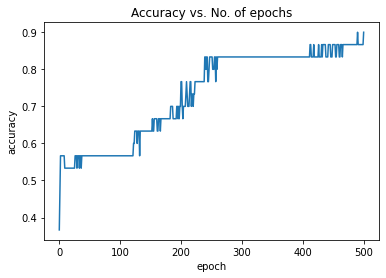

In [41]:
history = [result0] + history1 + history2 + history3 + history4 + history5
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

## Testing with individual images from the test set

In [42]:
features, label = dataset_test[0]
print('Shape:', features.shape)
print('Label:', label)

Shape: torch.Size([4])
Label: tensor(1)


In [43]:
def predict_iris_class(features, model):
    xb = features.unsqueeze(0)
    yb = model(xb)
    max_prob, preds = torch.max(yb, dim=1)
    return preds[0].item()

In [44]:
features, label = dataset_test[0]
print('Label:', label, ', Predicted:', predict_iris_class(features, model))

Label: tensor(1) , Predicted: 1


In [45]:
features, label = dataset_test[8]
print('Label:', label, ', Predicted:', predict_iris_class(features, model))

Label: tensor(2) , Predicted: 2


In [46]:
features, label = dataset_test[20]
print('Label:', label, ', Predicted:', predict_iris_class(features, model))

Label: tensor(1) , Predicted: 1


## Save model for further use from the already optimized weights and bias.

In [47]:
torch.save(model.state_dict(), 'iris-logistic.pth')

In [48]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.3732,  0.7703, -1.5759, -0.6673],
                      [-0.7641, -0.5061,  1.0630,  0.4621],
                      [ 0.1058, -0.2750, -0.1852,  0.0120]])),
             ('linear.bias', tensor([ 0.0898, -0.2157,  0.2445]))])

In [49]:
model2 = IrisModel()

In [50]:
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0079,  0.1870, -0.1858, -0.2525],
                      [ 0.1742, -0.0736, -0.1394, -0.1203],
                      [ 0.1697, -0.2799,  0.0132,  0.1780]])),
             ('linear.bias', tensor([-0.2770, -0.2362, -0.2273]))])

In [51]:
evaluate(model2, test_loader)   # With randomly initialized weights and biases

{'val_loss': 0.9163889288902283, 'val_acc': 0.5333333611488342}

In [52]:
model2.load_state_dict(torch.load('iris-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.3732,  0.7703, -1.5759, -0.6673],
                      [-0.7641, -0.5061,  1.0630,  0.4621],
                      [ 0.1058, -0.2750, -0.1852,  0.0120]])),
             ('linear.bias', tensor([ 0.0898, -0.2157,  0.2445]))])

In [53]:
result = evaluate(model2, test_loader)  # With the saved state after optimizing the weights and biases
result

{'val_loss': 0.35298052430152893, 'val_acc': 0.9000000357627869}